In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

import qexpy as q
import scipy.stats as st

from helper import *

#main = pd.read_pickle("../Data/main_no_outliers.df")
main = pd.read_pickle("../Data/main_1.df")

TARGET = "lengths_behind"
ALL_FEATURES =  ["days_since_last_race_rel", "horse_record_rel", "jockey_record_rel", "trainer_record_rel", 
             "horse_rating_rel", "win_percent_rel", "declared_weight_rel", 
             "actual_weight_rel", "last_race_result_rel", "last_refined_score_rel", 
             "last_raw_score_rel", "mean_raw_score_rel", "mean_ref_score_rel", "best_horse_record", 
             "best_going_record", "best_jockey_record", "best_trainer_record", 
             "best_win_percent"
]

In [2]:
def lengthsMakeBets_1(model, X_train, y_train, X_test, y_test, X_eval, y_eval, testing, betSize=1, startMoney = 100):
    testing = testing.reset_index()
    
    # Train and predict
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    evalPreds = model.predict(X_eval)
    
    # Eval to get error spread
    #RMSE = mean_squared_error(evalPreds, y_eval)

    races = np.unique(testing["race_id"])
    
    money = [float(startMoney)]
    for race_id in races:
        
        raceI = list(testing.loc[testing["race_id"]==race_id].index)
        
        temp_preds = preds[raceI]
        temp_act = y_test.iloc[raceI]
        odds = testing.iloc[raceI]["win_odds"].values
        
        predWinner = np.argmin(temp_preds, axis=0)
        actWinner = np.argmin(temp_act, axis=0)
        
        if predWinner == actWinner:
            newMoney = money[-1] - betSize + betSize*odds[predWinner]
        else:
            newMoney = money[-1] - betSize
            
        money.append(newMoney)
        
    return money

def lengthsMakeBets_2(model, X_train, y_train, X_test, y_test, X_eval, y_eval, testing, betSize=1, startMoney = 100):
    testing = testing.reset_index()
    
    # Train and predict
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    evalPreds = model.predict(X_eval)
    
    # Eval to get error spread
    RMSE = mean_squared_error(evalPreds, y_eval, squared=False)
    print(RMSE)

    races = np.unique(testing["race_id"])
    
    money = [float(startMoney)]
    betCount = 0.
    winCount = 0.
    totalUp = 0
    totalDown = 0
    for race_id in races:
        
        raceI = list(testing.loc[testing["race_id"]==race_id].index)
        
        temp_preds = preds[raceI]
        temp_probs = getProbs(temp_preds, RMSE)
        norm_probs = [i/sum(temp_probs) for i in temp_probs]
        temp_odds = [i**-1 for i in norm_probs]
        temp_act = y_test.iloc[raceI].to_numpy()
        odds = testing.iloc[raceI]["win_odds"].values
        
        for i in range(len(temp_preds)):
            newMoney = money[-1]
            b = odds[i] - 1
            p = norm_probs[i]
            q = 1 - p
            
            f = (b*p - q) / b
            
            if f > 0: # Means we should bet on this one
                bet = newMoney * f
                if bet > 1:
                    betCount += 1 
                    if bet < betSize:
                        if temp_act[i] == 1: # Won the bet
                            winCount+=1
                            newMoney = newMoney - bet + bet*odds[i]
                            totalUp += bet*odds[i]
                        else: # Lost the bet
                            totalDown += bet
                            newMoney -= bet
                    else:
                        if temp_act[i] == 1: # Won the bet
                            winCount+=1
                            totalUp += betSize*odds[i]
                            newMoney = newMoney - betSize + betSize*odds[i]
                        else: # Lost the bet
                            newMoney -= betSize
                            totalDown += betSize
            money.append(newMoney)
    #print("Percent bet on: {:.3f}".format(betCount/len(money)))
    #print("Percent of bets won: {:.3f}".format(winCount/betCount))
    print("Total up:", totalUp)
    print("Total down:", totalDown)
    return money

def xGy(x, y, e):
    d = q.Measurement(x, e) - q.Measurement(y, e)
    return st.norm.cdf((0-d.value)/d.error)

def getProbs(lens, e):
    probs = []
    for i in range(len(lens)):
        val = lens[i]
        prob = 1
        for j in range(len(lens)):
            if i==j:
                continue
            prob *= xGy(val, lens[j], e)
            
        probs.append(prob)
        
    return probs

def removeOutliers(data, thresh=40):
    data = data.copy()
    badRaceList = []
    for i in range(len(data)):
        run = data.iloc[i,:]
        if run["lengths_behind"]>thresh:
            race_id = run["race_id"]
            badRaceList.append(race_id)
            
    indexNames = data[data['race_id'].isin(np.unique(badRaceList))].index
    data.drop(indexNames, inplace=True)
    return data

82.79886718515202
Total up: 170.0
Total down: 256
71.04621271413947
Total up: 27.0
Total down: 116
76.60698862745487
Total up: 25.0
Total down: 112
62.54544495113914
Total up: 73.0
Total down: 159
62.979031985345216
Total up: 0
Total down: 90
54.70960675434521
Total up: 0
Total down: 90
76.77443212388536
Total up: 0
Total down: 88
94.62907064106277
Total up: 0
Total down: 89
83.25963557974809
Total up: 0
Total down: 91
89.03409136484578
Total up: 0
Total down: 90


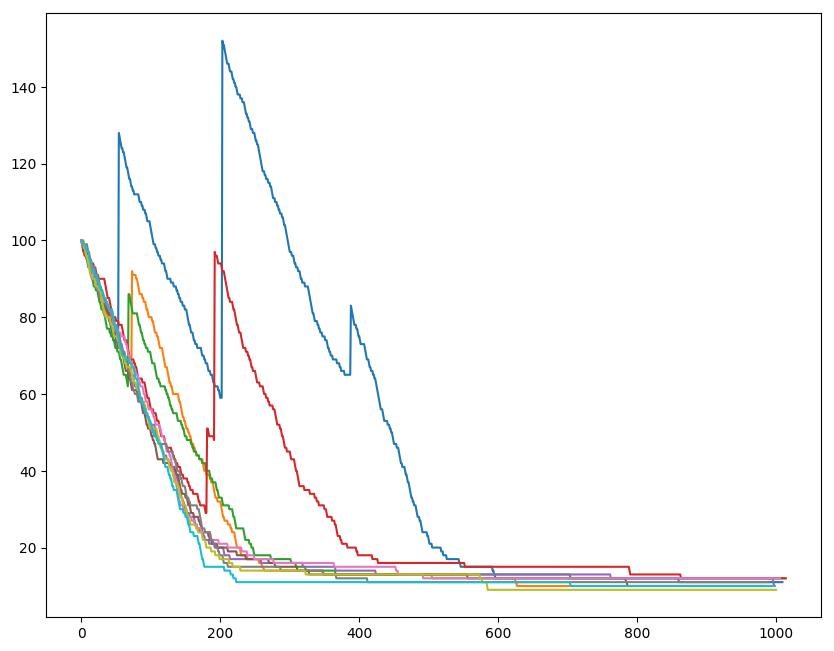

In [3]:
plt.figure(figsize=(10,8), dpi=100)
featureImp = np.zeros(len(ALL_FEATURES))
for training_evalu, testing in getCrossVal(main.iloc[:10000,:], 10):
    
    # Steal a small training dataset to get the RMSE val
    for training, evalu in getCrossVal(training_evalu, 10):
        training = removeOutliers(training)
        X_train = training[ALL_FEATURES]
        y_train = training[TARGET]
        
        X_eval = testing[ALL_FEATURES]
        y_eval = testing[TARGET]

        break
    
    model = GradientBoostingRegressor()
    
    X_test = testing[ALL_FEATURES]
    y_test = testing[TARGET]
    
    m = lengthsMakeBets_2(model, X_train, y_train, X_test, y_test, X_eval, y_eval, testing)
    
    plt.plot(m)
   

In [4]:
# THINK ABOUT REMOVING OUTLIERS FROM TRAINING DATA ??? 
# NEED TO CONVERT LENGTHS W ERROR TO WIN PROBS


In [5]:
print(xGy(1, 1, .5))

0.5
